# Les naufragés

Cher naufragés, vous voici embarqués pour une nouvelle aventure : découvrir la datascience.  Même si dans la vraie vie, la page de départ est vierge, ici vous avez une trame qui vous guidera (et un mentor qui peut vous aider si vous êtes perdus...)
Le client est un utilisateurs Whatsapp qui a perdu ses contacts et veux réattribuer chaque message à son auteur. On va donc utiliser la datasience pour prédire l'auteur d'un message, en nous basant sur l'historique de la conversation des naufragés.  
**Au boulot !**

## Première partie : ne pas réinventer la roue

Beaucoup de gens dans le monde ont déjà travaillé sur ces sujets et le grand principe en informatique, c'est d'être flemmard et de réutiliser ce qui a déjà été bien fait. Je commence donc par importer tous les outils, packages et autres bouts de codes qui nous serviront par la suite.

In [10]:
# Processing
import pandas as pd
import numpy as np
import os
import re
# Model
from transformers import CamembertTokenizer
from sklearn import preprocessing
from sklearn.svm import SVC
# Viualisation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


## Deuxième partie :  Text preprocessing

Ici, on va aller récupérer les données et les standardiser.

**En entrée :**  
La conversation whatsapp en format texte (ficher .txt) qui contient les messages à analyser.  
Par exemple : _Message du 12 mars 9h53 de @0685294172 à @06047412 : On se retrouve où ?_

**En sortie :**  
Un ensemble de vecteur mathématiques -> chaque vecteur est un ensemble de nombre.
Par exemple : 

- **message1**
    - message1_nombre1
    - message1_nombre2
    ...
    - message1_nombreN
- **message2**
    - message2_nombre1
    - message2_nombre2
    ...
    - message2_nombreN
    
On va y aller pas à pas...

#### 2.1 : Lire le fichier

In [12]:
# La ligne suivante lis le fichier et le stocke dans une variable.
full_text = open('../data/Discussion WhatsApp avec Les naufragés 🐠🏄_♀️🏝.txt', "r", encoding='utf8').read()

In [14]:
# Petit extrait juste pour voir à quoi ca ressemble
full_text[0:300]

'16/03/2020 à 13:26 - Les messages envoyés dans ce groupe sont désormais protégés avec le chiffrement de bout en bout. Appuyez pour plus d\'informations.\n16/03/2020 à 13:26 - \u200eThomas Redoulez a créé le groupe "Fuyons "\n16/03/2020 à 13:26 - \u200eThomas Redoulez vous a ajouté\n16/03/2020 à 13:26 - \u200eThomas Re'

#### 2.2 Extraire les info importantes du fichier

On veut récupérer le message et l'auteur du message. On va faire ça bien et récupérer aussi l'heure et la date même si on ne s'en servira pas. 

On utilise des REGEX (Regular Expression). Il s'agit d'une syntaxe informatique particulière qui sert à faire des recherche dans du texte.  
C'est affreux mais c'est très puissant.  
L'exemple le plus connu c'est "." qui signifie "n'importe quel caractère". Un exemple plus utile : "\[a-z\]" qui veut dire "n'importe quelle lettre en minuscule".

In [17]:
# REGEX
pattern = r'^([\d]{2}\/[\d]{2}\/[\d]{4}) à ([\d]{2}:[\d]{2}) - ([^:]+)\: (.*)$'
tech_pattern = r'^([\d]{2}\/[\d]{2}\/[\d]{4}) à ([\d]{2}:[\d]{2}) -'

On crée un "DataFrame" que l'on apelle _conversation_. C'est un objet informatique qui contient un tableau. On va y ranger nos données.

In [18]:
conversation = pd.DataFrame(columns=['date', 'hour', 'author', 'message'])

On execute un _boucle for_ :  
L'ordinateur va répéter une instruction en boucle sur un ensemble d'éléments.  
Dans chaque execution de la boucle, on détecte la date, heure, auteur et message de la ligne.

In [55]:
i = 0

for msg in full_text.split('\n'):
    s = re.search(pattern, msg)
    # petite astuce pour les plus perspicace : on ne range pas dans le tableau les messages qui ne "collent" pas au REGEX
    if s is not None:
        if i>0:            
            conversation.loc[i-1] = [date, hour, author, txt]
        i += 1
        date = s.group(1)
        hour = s.group(2)
        author = s.group(3)
        txt = s.group(4)
       
    # A la place on vient vérifier si c'est un message technique de whatsapp (changement d'icone, de nom de groupe)
    else:
        tech_s = re.search(tech_pattern, msg)
        if tech_s is None: # Si ce n'est pas le cas, alors le message précédent était sur plusieurs ligne
            txt = txt + "\n" + msg # On colle la nouvelle ligne à l'ancienne

conversation.loc[i-1] = [date, hour, author, txt]

ValueError: Must have equal len keys and value when setting with an iterable

On va voir à quoi ressemble notre tableau :

In [37]:
conversation

,date,hour,author,message
0,16/03/2020,13:42,Thomas Redoulez,RDV 15h30 Porte d'Italie à la station d'essence.
1,16/03/2020,15:00,Timothée Guez,@33608138060 et @33616905893 quelle décision p...
2,16/03/2020,15:01,Cleophee Martinot Lagarde,C’est quoi l’adresse? 27 avenue de la Porte d’...
3,16/03/2020,15:02,Timothée Guez,Exactement
4,16/03/2020,15:05,Thomas Redoulez,Oui !
...,...,...,...,...
657,22/04/2020,23:06,Marie-Gabriel Bourgue,Sympa vos marques de bronzage ;) 💪🏽💪🏽💪🏽
658,22/04/2020,23:18,Diane De Sentenac,
659,23/04/2020,11:39,Diane De Sentenac,
660,23/04/2020,11:39,Diane De Sentenac,


#### 2.3 Standardiser les données

A ce moment là, on utilise un projet de l'INRIA : CamemBERT. C'est un projet qui a analysé des centaines de Gb de textes français pour fournir une manière intelligente de transformer les mots en vecteurs. Ils ont obtenus de bons résultats, et on en profite.

In [56]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base') # tokenizer est le convertisseur mot <-> vecteurs
# Juste pour avoir un exemple...
print(tokenizer.encode("J'aime le camembert"))
print(tokenizer.encode("Vraiment j'aime le fromage"))
conversation = conversation[conversation['message'] != '<Médias omis>'].reset_index()
conversation['message'] = conversation['message'].map(lambda x: re.sub(r'[\W^\s]+', ' ', x))

[5, 121, 11, 660, 16, 730, 25543, 110, 6]
[5, 13532, 76, 11, 660, 16, 5271, 6]


Pour info, les début et fin de messages sont toujours encodé "5" et "6".  
On fait le même travail avec les noms des auteurs, qui doivent être transformés en chiffres. Là aussi un outil existe déjà.

In [57]:
le = preprocessing.LabelEncoder() # le (pour label encoder) est le convertisseur etiquette <-> nom d'auteur
le.fit(conversation.author) # Il faut lui fournir la liste des étiquettes pour qu'il sache comment convertir...

LabelEncoder()

On créé la fonction qu'on va appliquer au tableau.  
**Entrée :** message au format texte  
**Sortie :** Vecteur (ensemble de nombre)  

In [58]:
def transform_sentence(msg):
    l = len(tokenizer) # l est la taille du dictionnaire CamemBERT
    # On transforme le msg en chiffres
    sparse_vectors = tokenizer.encode(msg) 
    # On passe de '3' à [0,0,1,0,0...]
    vec = np.zeros(l)
    for sparse_vec in sparse_vectors:        
        vec[sparse_vec] = vec[sparse_vec] + 1
    return vec

On a maintenant tous les outils pour créer notre X, qui contiendra l'ensemble de nos données standardisées

In [59]:
X = np.array(len(conversation)) # Création de X vide
l = list()
for i, row in conversation.iterrows():
     # On applique la fonction à chaque ligne et on stocke le résultat dans une liste
    l.append(transform_sentence(row['message']))
X = np.array(l) # On place la liste dans X 

Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1011 > 512). Running this sequence through the model will result in indexing errors


On crée aussi le Y avec les étiquettes : les auteurs de chaque message.

In [60]:
Y = le.transform(conversation.author)

Fin de la transformation de données. On a maintenant X et Y, parfaitement structurés pour rentrer dans les algorithmes classiques de datascience.

### Troisième partie : modelisation de données

Cette partie sera rapide.  
J'ai choisi un algorithme assez classique qui s'appelle SVC (Support Vector  Clustering). Il n'y a pas besoin de le réécrire : tout est prêt à l'emploi.  

Le choix de l'algorithme est une question passionnante mais pas immédiate. C'est complexe et on commence généralement par faire quelque chose de simple mais qui marche, avant de se poser cette question.  

En avant pour la version "simple" donc.

In [76]:
clf = SVC(gamma=0.3)
clf.fit(X, Y) # Et hop, un simple ligne et l'apprentissage est fini.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Observons le résultat :

In [77]:
le.inverse_transform(clf.predict([transform_sentence("je")]))

array(['Marion Cadart'], dtype=object)

### Quatrième partie : visualisation de données

On va essayer de visualiser le top 20 des mots les plus utilisés par notre fan de Kaamelott.  
Pour ça, on commence par prédire l'ensemble de nos données :

In [72]:
predictions = clf.predict(X)

Nouvelle _boucle for_ :  
Pour chaque auteur, on sélectionne les message qui ont été predits comme étant de lui.  

Ensuite on additionne tous les mots et on stocke le tout dans une variable "atavisme".

In [73]:
atavism = {} # vide pour l'instant
for i in np.unique(predictions): # pour chaque auteur
    words_dict = {}
    personal_words = X[predictions == i] # personal_words contient l'ensemble des mots utilisés par l'auteur
    bag_of_words = personal_words.sum(axis=0) # on somme les vecteurs : mot 1 + mot 1 + mot 3 = [2, 0, 1]
    
    for token in bag_of_words.argsort()[-20:][::-1]: # On fait le top 20
        word = tokenizer.decode(int(token), skip_special_tokens=True)
        words_dict[word] = bag_of_words[token]
    del words_dict['<s>'] # on supprime les début de message -> code 5
    del words_dict['</s>']# on supprime les fin de message -> code 6
    atavism[str(le.inverse_transform([i])[0])] = words_dict # On ajoute le résultat à la variable atavism

Moment tant attendu : on visualise le tout !  

On fait un "nuage de mots". Ce format est très utilisé pour les textes.

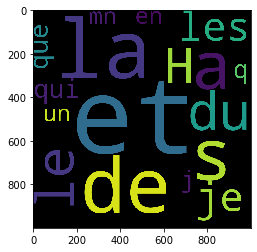

In [74]:
author = 'Diane De Sentenac'
wc = WordCloud(background_color="black",width=1000,height=1000, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(atavism[author])
plt.imshow(wc)

### Cinquième partie : à vous de jouer

On observe que c'est tout nul. Devinez-vous pourquoi ? Comment corriger ? 
Réponse en cliquant sur les 3 petit points.

On a laissé beaucoup de "parasites" : 
- la ponctuation
- les "médias omis" quand on envoie une photo sur whatsapp. 
- ...  
On va corriger ça en ajoutant  
```conversation = conversation[conversation['message'] != '<Médias omis>'].reset_index()```  
```conversation['message'] = conversation['message'].map(lambda x: re.sub(r'[\W^\s]+', ' ', x))```  
au preprocessing des données.
Que font ces lignes ? Où les mettre ?

Et si vous échouez, rappelez vous que c'est dans le thème.